#  pyam workflow notebook


Notebook testing composition and provenance configuration of a processing workflow using the pyam and dispel4py libraries

- https://pypi.org/project/pyam/
- https://gitlab.com/project-dare/dispel4py/

### Typical pyam script

The first cells show a typical use of the pyam library (from the pyam tutorial)

In [1]:
import pyam
from pyam.iiasa import valid_connection_names

<IPython.core.display.Javascript object>

In [2]:
valid_connection_names()


['iamc15']

In [3]:
df = pyam.read_iiasa_iamc15(
    model='MESSAGEix*',
    variable=['Emissions|CO2', 'Primary Energy|Coal'],
    region='World',
    meta=['category']
)

INFO:root:You are connected to the iamc15 scenario explorer. Please cite as:

D. Huppmann, E. Kriegler, V. Krey, K. Riahi, J. Rogelj, S.K. Rose, J. Weyant, et al., IAMC 1.5C Scenario Explorer and Data hosted by IIASA. IIASA & IAMC, 2018. doi: 10.22022/SR15/08-2018.15429, url: data.ene.iiasa.ac.at/iamc-1.5c-explorer


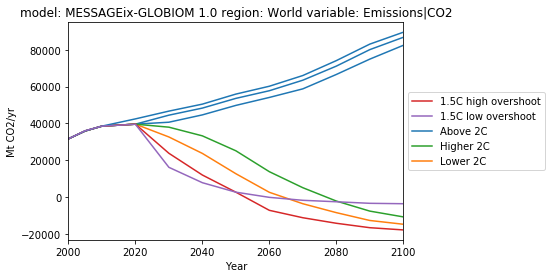

In [4]:
ax = df.filter(variable='Emissions|CO2').line_plot(
    color='category',
    legend=dict(loc='center left', bbox_to_anchor=(1.0, 0.5))
)

In [5]:
from dispel4py.provenance import *
from dispel4py.core import GenericPE
from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE
from dispel4py.workflow_graph import WorkflowGraph
import dispel4py.new.simple_process as simple_process

### Workflow implementation


The processing elements (PEs) of the workflow can be developed as simple functions or classes directly within the notebook.

Python functions can wrap atomic pyam actions.

In [6]:

        
def read_iiasa_iamc15(model,variable,region, meta):
    
    df = pyam.read_iiasa_iamc15(
        model=model,
        variable=variable,
        region=region,
        meta=meta
        )
     
    return df

def filter(data,variable):
    return data.filter(variable=variable)

def line_plot(data,color,legend):
     
    return data.line_plot(color=color,legend=legend)



class StoreData(ConsumerPE):
    def __init__(self):
        ConsumerPE.__init__(self)
        self._add_output('output')
        

    def _process(self, data):
        self.log(data)
        filelist = {}
        self.write('output',data)

### Workflow specification

The workflow is specified in a python function returning a graph object

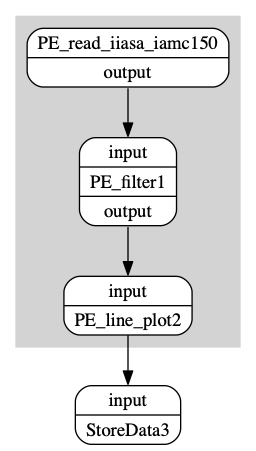

In [7]:
def build_workflow():
    graph = WorkflowGraph()
    
    wf = create_iterative_chain([(read_iiasa_iamc15,{
                            'variable':['Emissions|CO2', 'Primary Energy|Coal'],
                            'region':'World',
                            'meta':['category']}),
                            (filter,{'variable':'Emissions|CO2'}),
                            (line_plot,{'color':'category',
                                        'legend':{'bbox_to_anchor':(1.0, 1.0),'loc':'center left'}})]
                            , FunctionPE_class=SimpleFunctionPE)
    store = StoreData()
     
    graph.connect(wf,'output',store,'input')
    return graph
    

graph=build_workflow() 
from dispel4py.visualisation import display
display(graph)
    


### Input data preparation

Eeach key of the dictionary refers to the PE and contains the list (stream) of data passed on its input ports

In [8]:
input_data = {
    "PE_read_iiasa_iamc15": [
        {
            "input": 'MESSAGEix*'
        }
    ]
}

#### Execution function

In [9]:
def runExampleWorkflow(graph):
                                                     
                      
    graph.flatten()
    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print("\n RESULT: "+str(result))

#runExampleWorkflow(graph)

### Provenance Configuration

The workflow can be configured to capture provenance and lineage information by populating a json dictionary, according to specific metadata and precision requirements.

- 's-prov:componentsType': assigns provenance types and clusters to the workflow element overriding defaults
- 's-prov:WFExecutionInputs': specifies the initial input data of the workflow. Anything relevant can be mentioned in a list of dictionaries


- 'ProvenanceType.REPOS_URL' and 'ProvenanceType.PROV_EXPORT_URL' specify the endpoint of the provenance service for storage and extraction. The service used is the s-ProvFlow system

https://gitlab.com/project-dare/s-ProvFlow


Change grouping implementation 
PE_filter Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class 'dispel4py.base.SimpleFunctionPE'>)
PE_line_plot Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class 'dispel4py.base.SimpleFunctionPE'>)
PE_read_iiasa_iamc15 Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class 'dispel4py.base.SimpleFunctionPE'>)
StoreData Original base class: (<class 'dispel4py.base.ConsumerPE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.StoreData'>)
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
NewWorkflowRun8: BUILDING INITIA

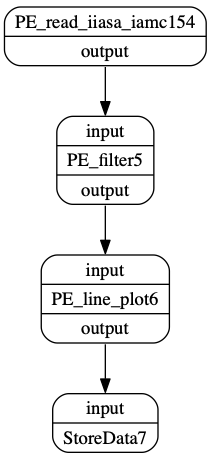

In [10]:
ProvenanceType.REPOS_URL='http://testbed.project-dare.eu/prov/workflowexecutions/insert'
ProvenanceType.PROV_EXPORT_URL='http://testbed.project-dare.eu/prov/workflowexecutions/'


#ProvenanceType.REPOS_URL='http://127.0.0.1:8082/workflowexecutions/insert'
#ProvenanceType.PROV_EXPORT_URL='http://127.0.0.1:8082/workflowexecutions/'


#Store to local path
ProvenanceType.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=1

prov_config =  {
                    'provone:User': "aspinuso", 
                    's-prov:description' : "provdemo IPCC",
                    's-prov:workflowName': "demo_ipcc",
                    's-prov:workflowType': "ipcc:preprocess",
                    's-prov:workflowId'  : "workflow process",
                    's-prov:save-mode'   : 'service'         ,
                    's-prov:WFExecutionInputs':  [{
                        "url": "",
                        "mime-type": "text/json",
                        "name": "input_data",
                        "value":input_data
                         
                     }],
                    # defines the Provenance Types and Provenance Clusters for the Workflow Components
                    's-prov:componentsType' : 
                                       {
                                        },
                    's-prov:sel-rules': None
                }



def createGraphWithProv():
    
    graph = build_workflow()
    # Ranomdly generated unique identifier for the current run
    rid='IPCC_PREPROC'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    

     
    #Initialise provenance storage to service:
    configure_prov_run(graph, 
                     provImpClass=(ProvenanceType,),
                     runId=rid,
                     sprovConfig=prov_config
                    )
    
    return graph,rid


graph,rid=createGraphWithProv()

display(graph)

#### Let's Run!

INFO:root:You are connected to the iamc15 scenario explorer. Please cite as:

D. Huppmann, E. Kriegler, V. Krey, K. Riahi, J. Rogelj, S.K. Rose, J. Weyant, et al., IAMC 1.5C Scenario Explorer and Data hosted by IIASA. IIASA & IAMC, 2018. doi: 10.22022/SR15/08-2018.15429, url: data.ene.iiasa.ac.at/iamc-1.5c-explorer


PE_read_iiasa_iamc154: BUILDING INITIAL DERIVATION
PE_read_iiasa_iamc154: <class 'dispel4py.base.IterativePE'>
PE_filter5: <class 'dispel4py.base.IterativePE'>
PE_line_plot6: <class 'dispel4py.base.IterativePE'>
StoreData7: AxesSubplot(0.125,0.125;0.775x0.755)
PE_read_iiasa_iamc154: Postprocess: (200, 'OK', b'{"success": true, "inserts": ["PE_read_iiasa_iamc154_write_orfeus-as-17740-e890753c-faf8-11e9-8627-f45c89acf865"]}')
PE_filter5: Postprocess: (200, 'OK', b'{"success": true, "inserts": ["PE_filter5_write_orfeus-as-17740-e892da0c-faf8-11e9-8627-f45c89acf865"]}')
PE_line_plot6: Postprocess: (200, 'OK', b'{"success": true, "inserts": ["PE_line_plot6_write_orfeus-as-17740-e8af6c76-faf8-11e9-8627-f45c89acf865"]}')
StoreData7: Postprocess: (200, 'OK', b'{"success": true, "inserts": ["StoreData7_write_orfeus-as-17740-e8af78f6-faf8-11e9-8627-f45c89acf865"]}')
SimplePE: Processed 1 iteration.

 RESULT: {'StoreData7': {'output': [{'_d4p': <matplotlib.axes._subplots.AxesSubplot object at 0x1

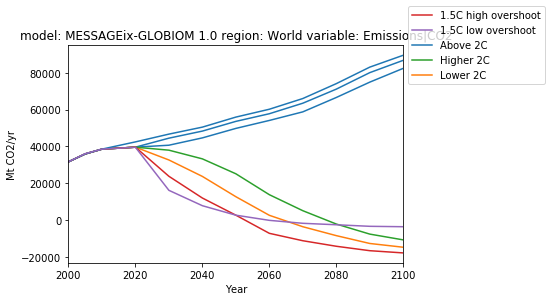

In [11]:
runExampleWorkflow(graph)

### Extract Provenance 

The complete workflow's run lineage can be extracted in different formats (xml|rdf)

In [12]:
import xml.etree.ElementTree as ET

print("Extract Trace for run: "+rid)
expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.client.HTTPConnection(expurl.netloc)
url="http://"+expurl.netloc+expurl.path+rid+"/export?level=100&format=xml"

print(url)
connection.request(
                "GET", url)
response = connection.getresponse()
  
print("progress: " + str((response.status, response.reason)))
prov1 = ET.fromstring(response.read())
print('PROV TO EMBED:')
print(str(prov1))

Extract Trace for run: IPCC_PREPROCorfeus-as-17740-e1257fb8-faf8-11e9-8627-f45c89acf865
http://127.0.0.1:8082/workflowexecutions/IPCC_PREPROCorfeus-as-17740-e1257fb8-faf8-11e9-8627-f45c89acf865/export?level=100&format=xml
progress: (200, 'OK')
PROV TO EMBED:
<Element '{http://www.w3.org/ns/prov#}document' at 0x11d030c28>


## Visualisation 

Once extracted, the provenance can be visualised in the notebook, 
Otherwise and more practical, it can be accessed interactively in the sprovflow-viewer:

http://127.0.0.1:8080/sprovflow-viewer/html/view.jsp

Entering the username will show a list of latest execution. Users can search and select which one to analyse.

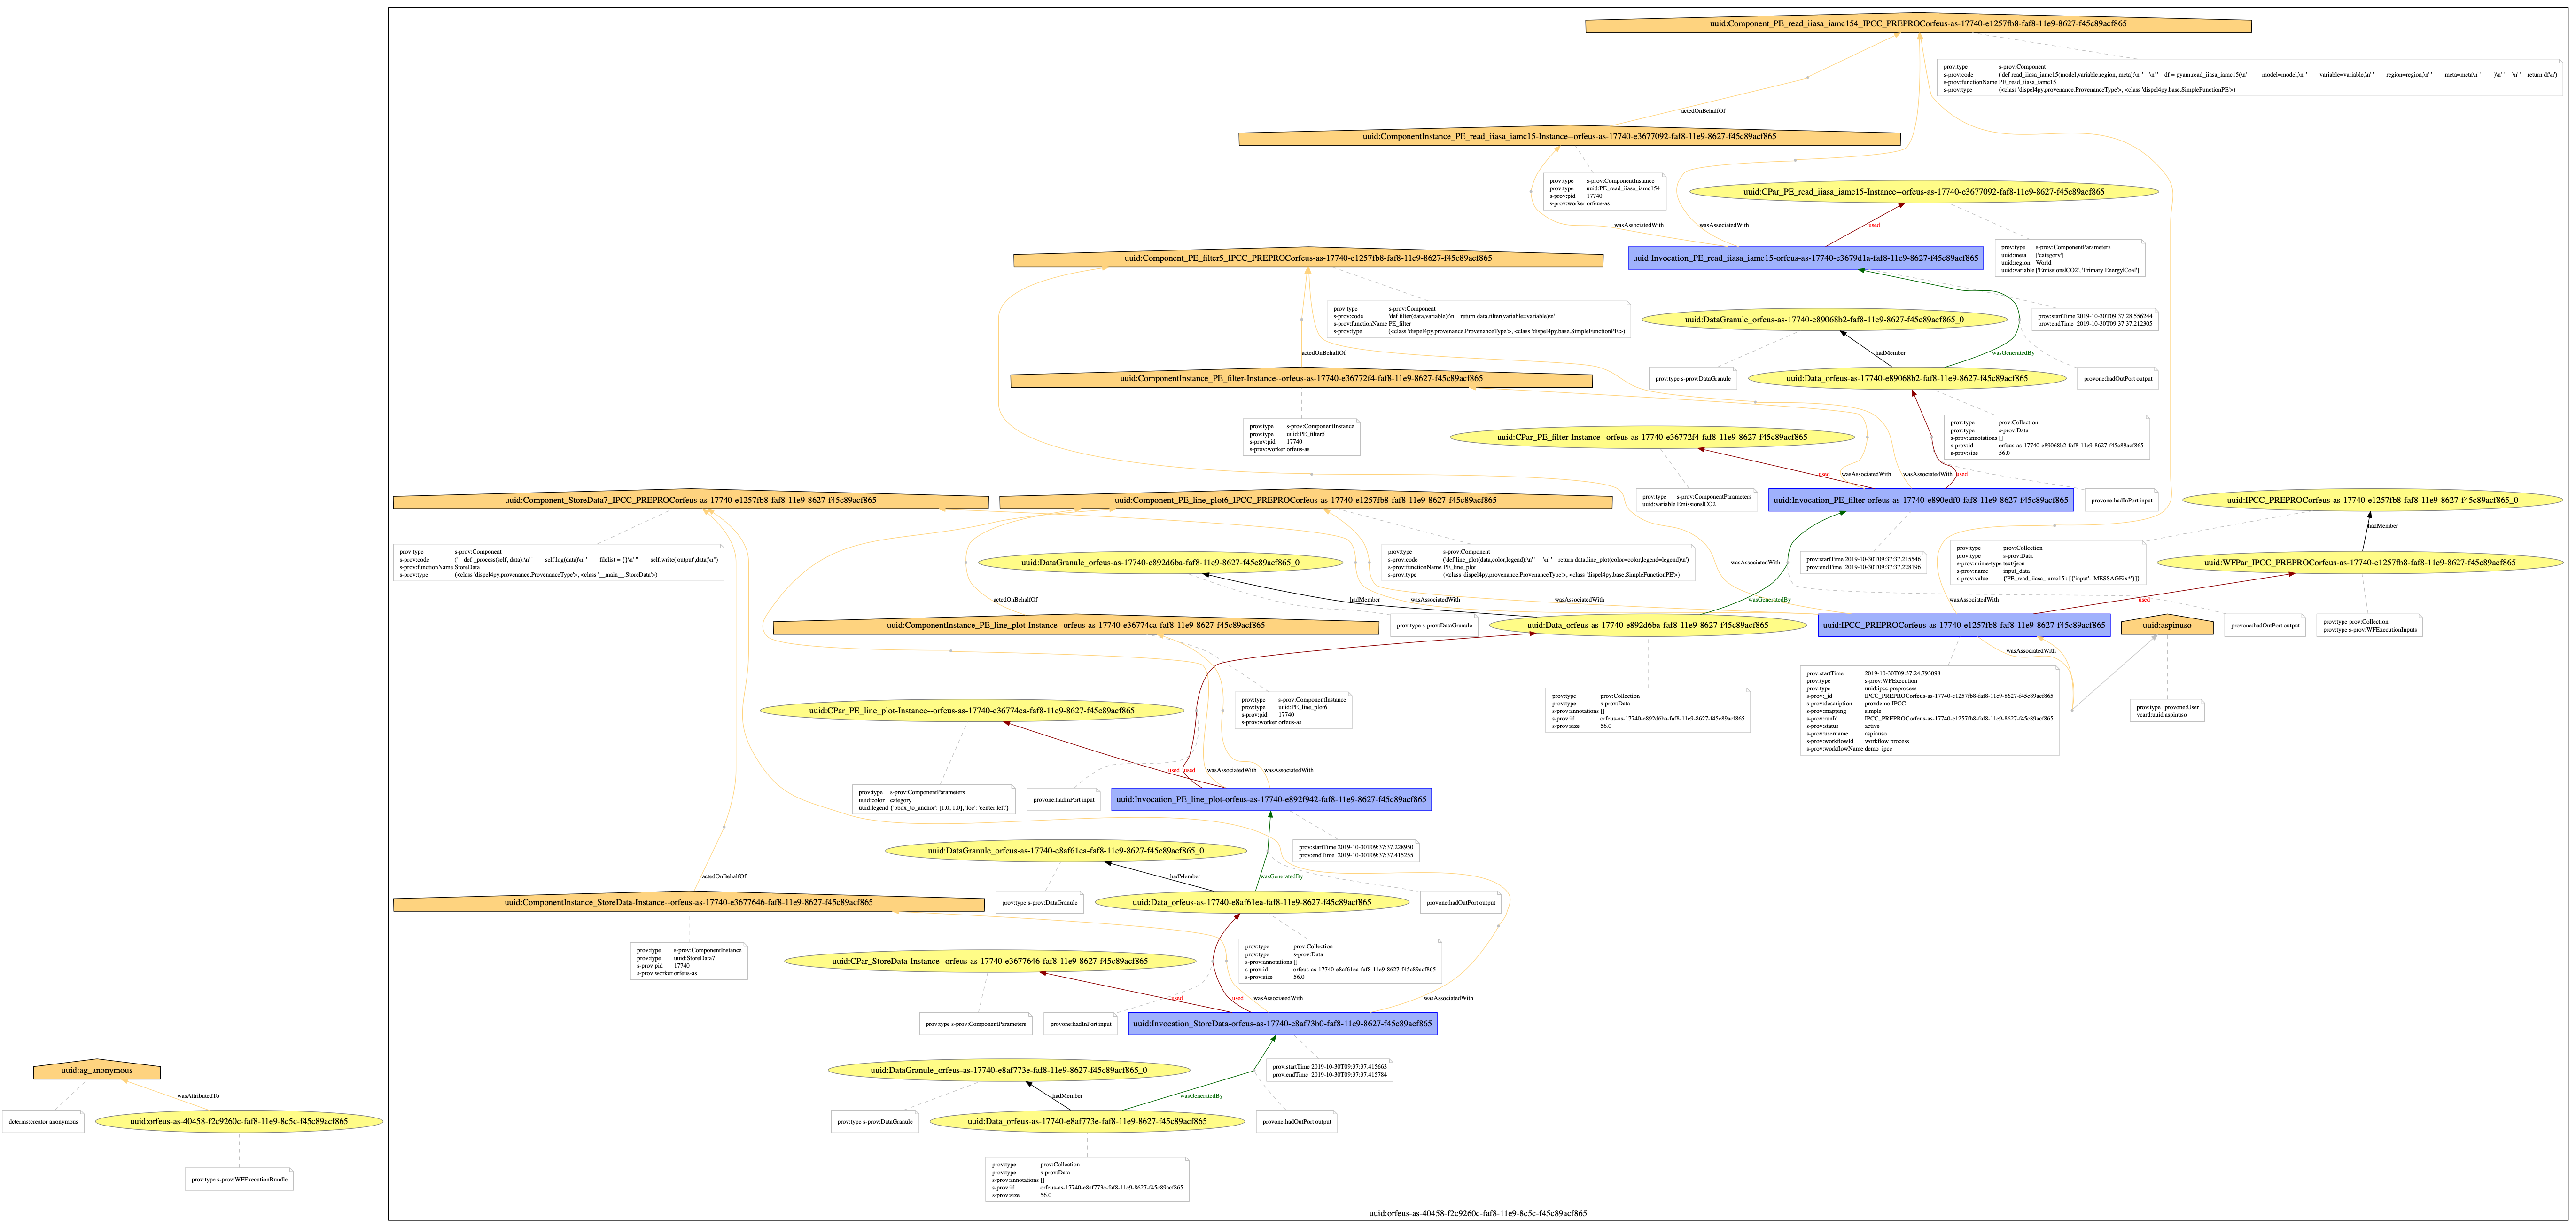

In [13]:
import prov
from IPython.display import Image
import io
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provURLToPNG(xml,format):
     
    xml_doc = io.BytesIO(urllib.request.urlopen(xml).read())
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    
    if format=="png":
        dot.write_png('PROV.png')
        return 'PROV.png' 
    if format=="svg":
        dot.write_svg('PROV.svg')
        return 'PROV.svg'
    
    


png_content=provURLToPNG(url,"png")

Image(png_content)